#Gather trajectories

In [4]:
import numpy as np
import process_data
process_data = reload(process_data)
folder = '../annotations/coupa/video2/'
fname = folder + 'annotations.txt'
x_raw,y_raw = process_data.get_trajectories(fname,label="Biker")

from PIL import Image
fname = folder + 'reference.jpg'
im = Image.open(fname)
width,height = im.size
print "width = %f, height = %f" % (width,height)
x_data = map( lambda x: x-width/2 , x_raw )
y_data = map( lambda x: x-height/2 , y_raw )

width = 1980.000000, height = 1093.000000


In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

(-1000.0, 1000.0, -600.0, 600.0)

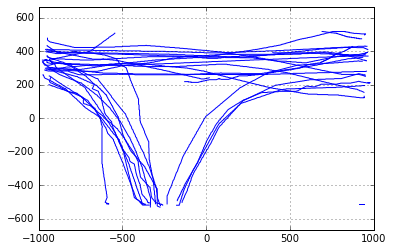

In [6]:
for k in range(len(x_data)):
    plt.plot(x_data[k], y_data[k],'b-')
plt.grid()
plt.axis('equal')

## Clustering
We will start by clustering the trajectories based upon there start-end conditions.

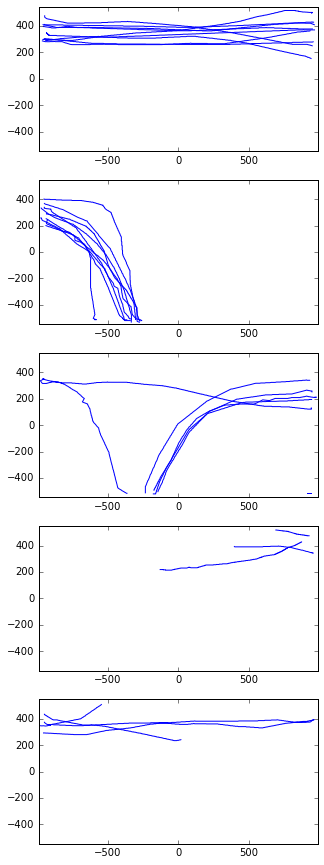

In [15]:
import pedestrian_potentials as pp
curves = map( np.vstack , zip(x_data, y_data) )
curves = pp.prune_trajectories( curves )
cluster = pp.cluster_trajectories( curves )
n_cluster = len(cluster)
fig, ax_arr = plt.subplots( n_clusters , 1 , figsize = (5,15))
for k,cl in enumerate(cluster):
    for curve in cl:
        ax_arr[k].plot( curve[0] , curve[1] , 'b-')
        ax_arr[k].axis( [-width/2, width/2, -height/2, height/2])

## The Model
We assume the trajectories are generated from Lagrangian dynamics with respect to a Lagrangian of the form
$$
    L(q,v;m,\theta) = \frac{m}{2} v^2 + V(q;\theta).
$$
The potential function is parametrized by $\theta$ and takes the form
$$
    V(x,y ; \theta) = \sum_{k_1,k_2=0}^{k_\max} \theta[k_1,k_2] L_{k_1}(2x/w) L_{k_2}(2 y/h)
$$
where $L_k$ is the $k$th Legendre polynomial and $w,h$ are the width and height of the domain which is $[.

## Cost function
We hypothesize the trajectories are (roughly) generated by Euler-Lagrange equations with respect to a simple mechanical Lagrangian.  In order to learn the Lagrangian we consider what statistical mechanics dubs the *canonical distribution*
$$
    \rho_{can}(q,v; m,\theta) = \frac{1}{Z(\theta)} e^{- E(q,v;m,\theta) }
$$
where $Z(m,\theta) = \int e^{-E(q,v;m,\theta)} dq dv$.

We desire to learn the parameters $\theta$ by minimizing an appropriate cost function.
A reasonable cost function is the negative log likelyhood
$$
     C_1(m,\theta) = - \log\left[ \left( \prod_{k=0}^{N} \rho(q_{k} , v_{k} ;\theta) \right)^{1/N} \right] =
     \log \left(Z(\theta,m) \right) + \frac{1}{N} \sum_{k} E(q_k,v_k;\theta)
$$
As $\partial_\theta H(\cdot ; \theta) = \partial_\theta V( \cdot ; \theta)$
and
$$
    \log( Z(m,\theta) ) = \log \left( \int e^{-mv^2/2} dv \right) + \log\left( \int e^{-V(q,\theta)} dq \right) = \sqrt{\frac{2\pi}{m} } + \log\left( \int e^{-V(q,\theta)} dq \right)
$$

we can just use the cost function
$$
    C(m,\theta) = \sqrt{ 2\pi / m } + \log\left( \int e^{-V(q,\theta)} dq \right) + \frac{1}{N} \sum_{k}\frac{m}{2} v_k^2 + V(q_{k})
$$
  Taking a partial derivative with respect to $m$ we can see that the optimal $m$ is
$$
    m^* = \left[ (2\pi)^{-1/2} \cdot \left( \frac{1}{N} \sum_{k=1}^{N} v_k^2 \right) \right]^{-2/3}
$$
So we can focus on minimizing
$$
    C(\theta) = \log\left( \int e^{-V(q,\theta)} dq \right) + \frac{1}{N} \sum_{k}V(q_{k})
$$
which has a tendency to minimize $V$ on the points $q_k$, while maximizing $V$ everywhere else.  It's notable that this problem is not well-posed on $C^1$-functions.  We should probably include a regularization somewhere.
This suggests the cost function
$$
    C(\theta) = \log\left( \int e^{-V(q,\theta)} dq \right) + \frac{1}{N} \sum_{k}V(q_{k}) + R(\theta)
$$
where $R(\theta) =  \sqrt{ \sum_{k_1,k_2 = 0}^{k_\max} (k_1^2+k_2^2) \theta[k_1,k_2]}$

In [54]:
points = np.hstack( cluster[1] )
theta = pp.learn_potential( points[0], points[1], width, height)

Percent: [##--------] 17.5% Optimization terminated successfully.


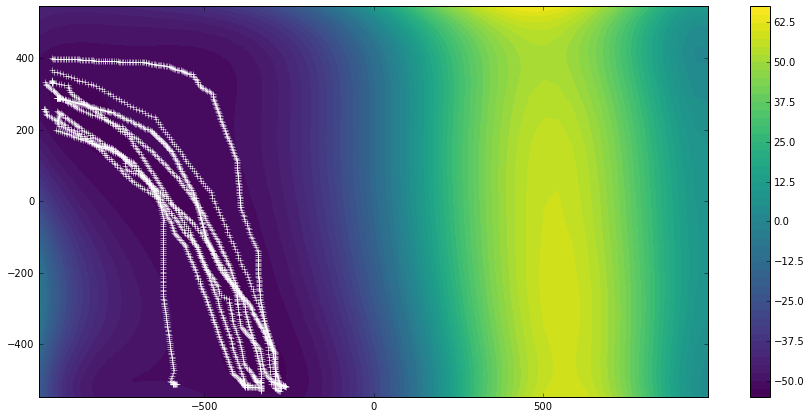

In [56]:
x_grid,y_grid = np.meshgrid( np.linspace(-width/2,width/2,50) , np.linspace(-height/2,height/2,50))
V_scale = (1.2*width/2, 1.2*height/2)
from numpy.polynomial.legendre import legval2d
V = legval2d(x_grid/V_scale[0] , y_grid/V_scale[1], theta)
fig = plt.figure(figsize=(15,7))
plt.contourf(x_grid,y_grid,V , 50, cmap='viridis')
plt.colorbar()
plt.plot( points[0] , points[1], 'w+')
plt.show()

## Sanity check
Let's see if we can reproduce the blue curves in the above plot using Stormer Verlet.

229


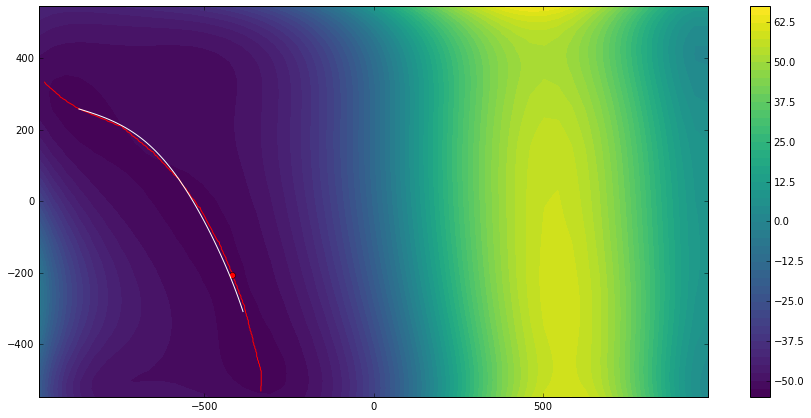

In [93]:
# Choose a curve from the first cluster
pp = reload( pp)
x_arr, y_arr = list(cluster[1][0])
start = 30
x0 = x_arr[start]
x1 = x_arr[start+1]
y0 = y_arr[start]
y1 = y_arr[start+1]

print x_arr.size
n_steps = 120
x_pred, y_pred = pp.Stormer_Verlet(x0, y0, x1, y1, n_steps, theta, V_scale, Delta_t = 3.1 )
fig = plt.figure(figsize=(15,7))
plt.contourf(x_grid,y_grid,V , 50, cmap='viridis')
plt.colorbar()
plt.plot( x_arr, y_arr, 'r-')
plt.plot( x_arr[start+n_steps], y_arr[start+n_steps], 'ro')
plt.plot( x_pred , y_pred, 'w-')
plt.show()

## Modified Hausdorff Distance
The modified Hausdorff distance between two point sets is given by
$$
    d_{MHD}(A,B) = \max( \phi(A,B) , \phi(B,A) )
$$
where
$$
    \phi(A,B) = \frac{1}{N_a} \sum_{a \in A} \inf_{b \in B} \| a-b \|
$$

In [499]:
def modified_Hausdorff_distance(x_a, y_a, x_b, y_b):
    #computes the modified Hausdorff distance between two point sets.
    return max( mhd_helper(x_a, y_a, x_b, y_b) , mhd_helper(x_b, y_b, x_a, y_a) )

def mhd_helper(x_a, y_a, x_b, y_b):
    out = 0
    for x,y in zip(x_a,y_a):
        out += np.sqrt( np.min( (x_b - x)**2 + (y_b-y)**2 ) )
    out = out / len(x_a)
    return out

print "Testing mhd"
n=1
x_a = np.random.randn(n)
y_a = np.random.randn(n)
x_b = np.random.randn(n)
y_b = np.random.randn(n)

print mhd_helper(x_a,y_a,x_b,y_b)
print modified_Hausdorff_distance(x_a,y_a,x_b,y_b)

print np.sqrt( (x_a-x_b)**2 + (y_a-y_b)**2 )

Testing mhd
1.62488812322
1.62488812322
[ 1.62488812]
